### Imports / globals

In [1]:
import os

import pandas as pd
import numpy as np

import cv2
import torch
import torchvision
from torchvision import transforms
from sklearn.metrics import cohen_kappa_score

from tensorboardX import SummaryWriter

from efficientnet_pytorch import EfficientNet


from utils import get_split_indices, seed_everything, prepare_train_directories
from utils.checkpoint import *
from models.model_factory import get_resnet50
from datasets.dataset_factory import SmallDataset, ExternalDataset
from utils.train_helpers import train, train_single_epoch, evaluate_single_epoch
from utils.find_lr import LRFinder

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

%load_ext autoreload
%autoreload 2

/home/l3404/anaconda3/envs/wombat/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
def seed_everything(seed=1358):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

### External

In [3]:
NUM_FOLD = 0 #0-4
EXPERIMENT_NAME = 'effb4.fastai.ext_{}'.format(NUM_FOLD)
RESULTS_DIR = os.path.join('results', EXPERIMENT_NAME)
CHECKPOINT_DIR = os.path.join(RESULTS_DIR, 'checkpoint')
DATA_DIR = 'data'
IMAGES_DIR = os.path.join(DATA_DIR, 'train-cropped-1024')
IMAGES_EXTERNAL_DIR = os.path.join(DATA_DIR, 'external-1024-cropped')
BATCH_SIZE = 32
IMAGE_SIZE = 260

#seed_everything(0) # Does this work??
prepare_train_directories(RESULTS_DIR)

In [4]:
df = pd.read_csv(os.path.join(DATA_DIR, 'external-1024-cropped.csv')) # external.csv
#df = df.rename(columns={'id_code': 'name', 'diagnosis': 'label'})
df['path'] = df['id_code'].apply(lambda x: os.path.join(IMAGES_EXTERNAL_DIR, x + '.jpeg'))
#train_idx, val_idx = get_split_indices(df)[NUM_FOLD]
# train_df = df.iloc[train_idx]
# val_df = df.iloc[val_idx]

#df['is_valid'] = False
#df['is_valid'].iloc[val_idx] = True
#zeroes = df[df['diagnosis'] == 0].sample(n=5000, random_state=0)
#df = df[df.diagnosis != 0]
#df = pd.concat([df, zeroes]).reset_index()

In [5]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [6]:
def _load_format(path, convert_mode, after_open)->Image:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0), 10) ,-4 ,128)
                    
    return Image(pil2tensor(image, np.float32).div_(255)) #return fastai Image format

vision.data.open_image = _load_format

In [7]:
# src = (
#     ImageList.from_df(df,path='',cols='path')
#         .split_by_rand_pct(0.2, seed=42)
#         .label_from_df(cols='diagnosis',label_cls=FloatList)    
#     )


In [8]:
transforms = get_transforms(do_flip=True, flip_vert=True, max_rotate=0.40, max_zoom=1.3, max_warp=0.0, max_lighting=0.2)

data = (ImageList.from_df(df=df,path='',cols='path') 
        #.split_from_df(col='is_valid')
        .split_by_rand_pct(0.2, seed=42)
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(transforms, size=260) 
        .databunch(bs=BATCH_SIZE, num_workers=12) 
        .normalize(imagenet_stats)  
       )

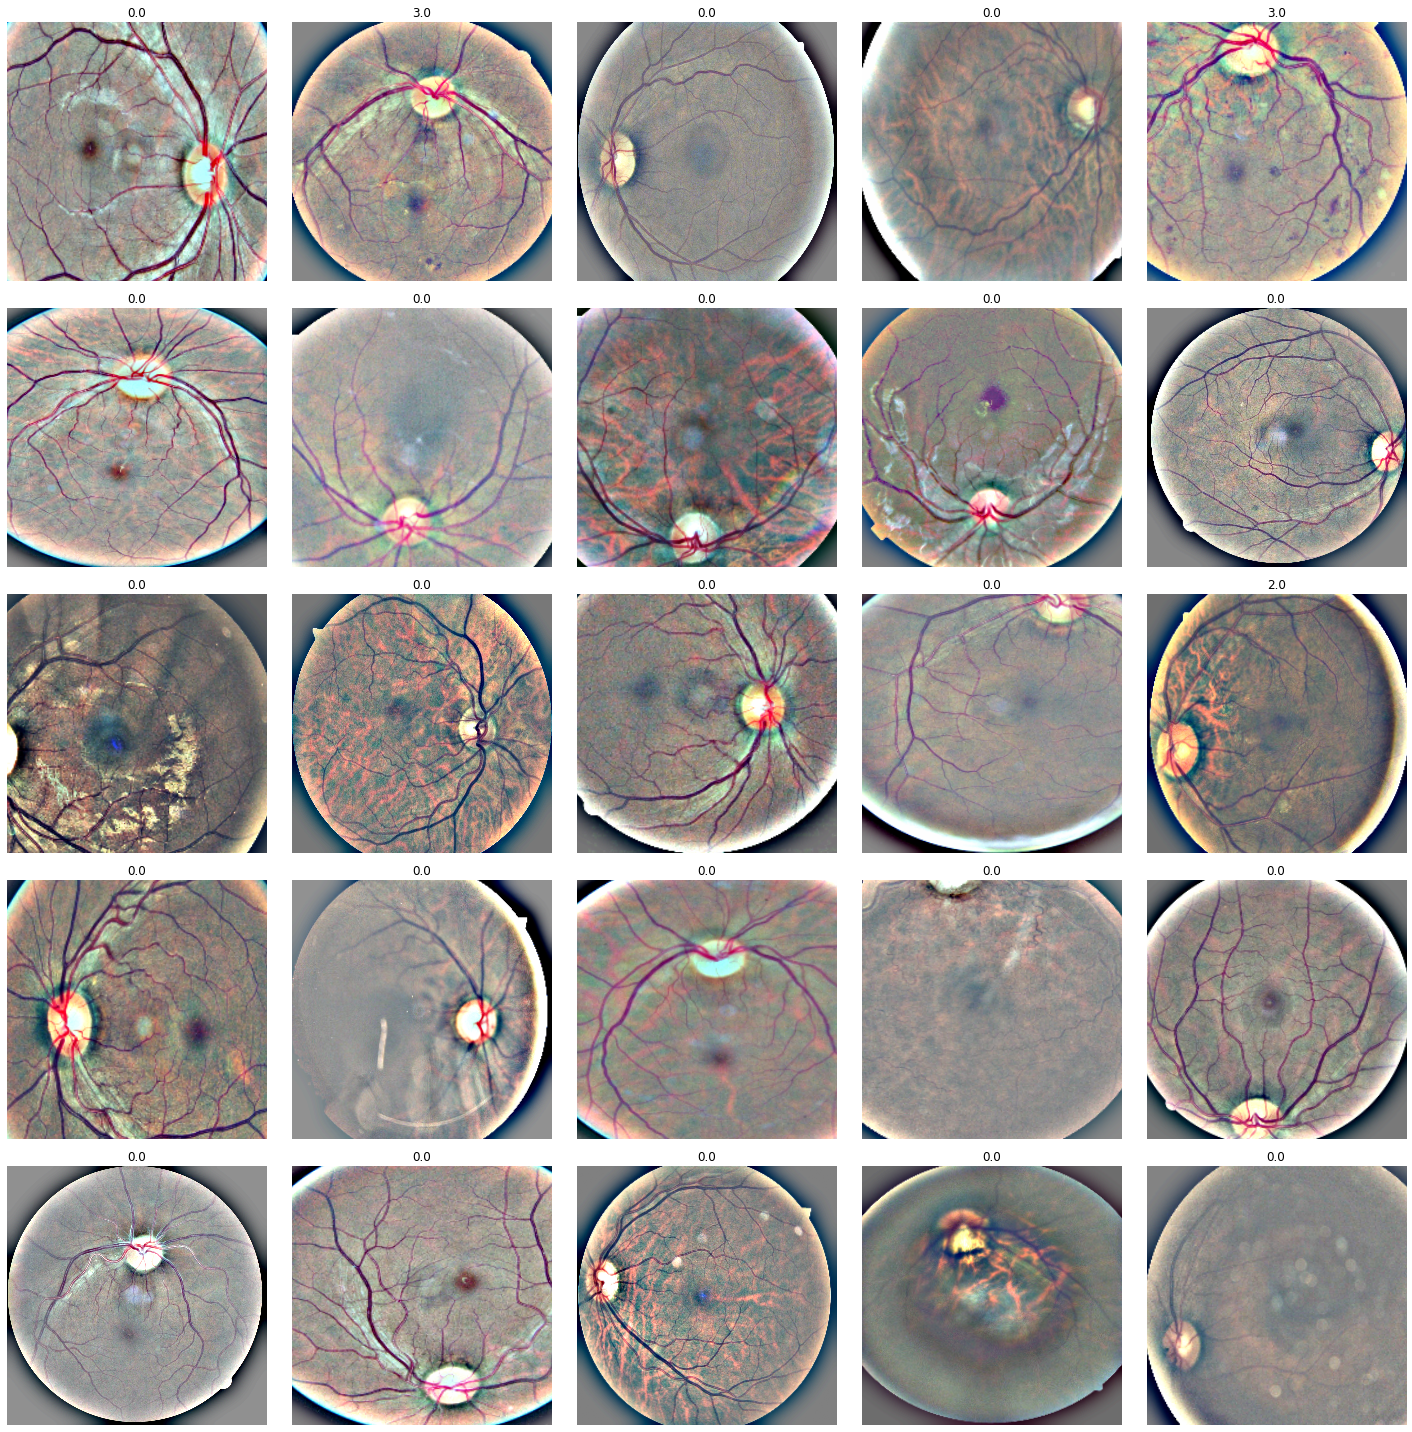

In [9]:
data.show_batch()

In [9]:
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device='cuda:0')

In [10]:
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=1) 

Loaded pretrained weights for efficientnet-b4


In [19]:
learn = Learner(data, model ,metrics=[quadratic_kappa],
                    model_dir=RESULTS_DIR).to_fp16().clip_grad(10)

In [20]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

In [21]:
learn = learn.split(lambda m: (m._conv_head))

In [23]:
learn.freeze()

In [24]:
lr = 1e-2
learn.fit_one_cycle(3, lr)

KeyboardInterrupt: 

In [ ]:
learn.unfreeze()
lr = 3e-4
learn.fit_one_cycle(3, lr)

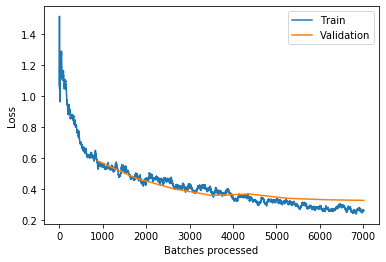

In [16]:
learn.recorder.plot_losses()

In [17]:
learn.save(EXPERIMENT_NAME, return_path=True)

PosixPath('results/effb4.fastai.pre_0/effb4.fastai.pre_0.pth')

### Main data

In [28]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')) # external.csv
#df = df.rename(columns={'id_code': 'name', 'diagnosis': 'label'})
df['path'] = df['id_code'].apply(lambda x: os.path.join(IMAGES_DIR, x + '.png'))
#train_idx, val_idx = get_split_indices(df)[NUM_FOLD]
# train_df = df.iloc[train_idx]
# val_df = df.iloc[val_idx]

#df['is_valid'] = False
#df['is_valid'].iloc[val_idx] = True
#zeroes = df[df['diagnosis'] == 0].sample(n=5000, random_state=0)
#df = df[df.diagnosis != 0]
#df = pd.concat([df, zeroes]).reset_index()

In [29]:
transforms = get_transforms(do_flip=True, flip_vert=True, max_rotate=0.40, max_zoom=1.3, max_warp=0.0, max_lighting=0.2)

data = (ImageList.from_df(df=df,path='',cols='path') 
        #.split_from_df(col='is_valid')
        .split_by_rand_pct(0.2, seed=42)
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(transforms, size=260) 
        .databunch(bs=BATCH_SIZE, num_workers=12) 
        .normalize(imagenet_stats)  
       )

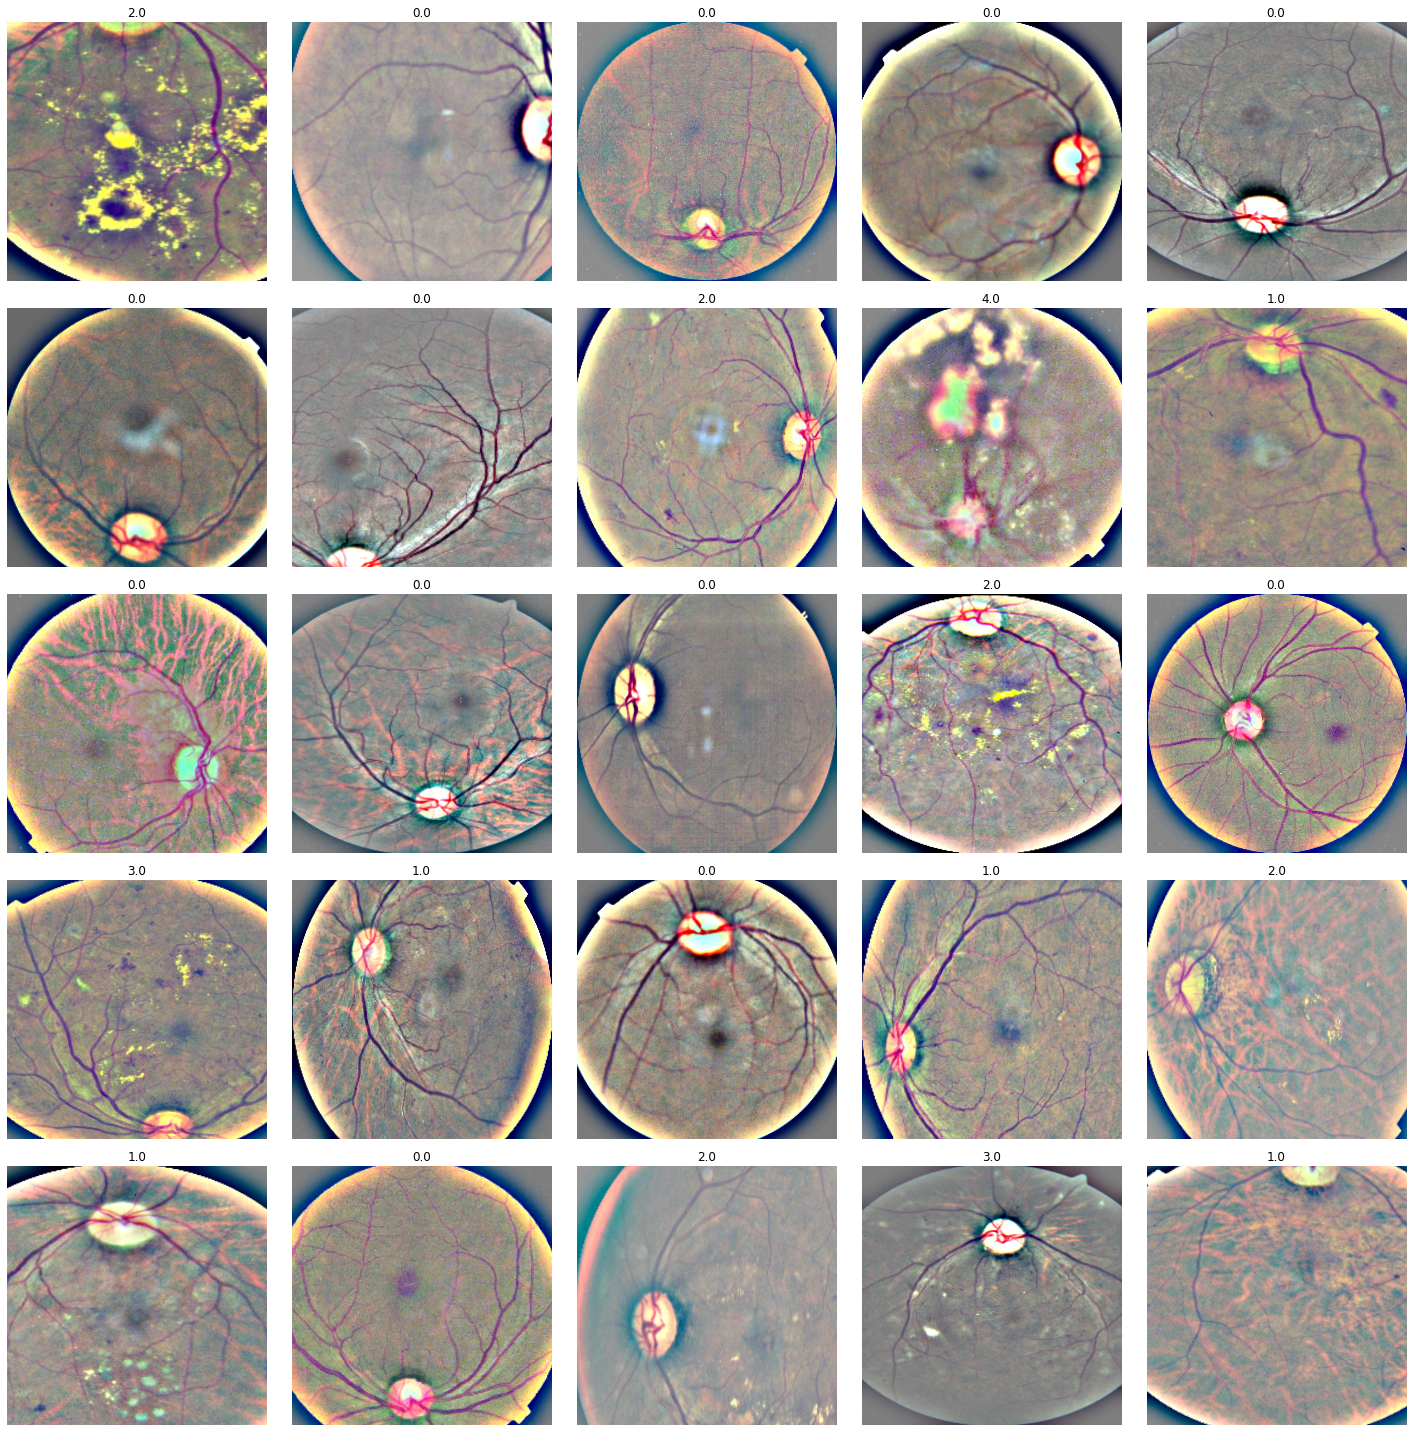

In [30]:
data.show_batch()

In [31]:
#model = torch.load('results/effb4.fastai.pre_0/effb4.fastai.pre_0-ext.pth')
model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=1) 
learn = Learner(data, model ,metrics=[quadratic_kappa],
                    model_dir=RESULTS_DIR).to_fp16()
learn.load('effb4.fastai.pre_0-ext1-fullset')

Loaded pretrained weights for efficientnet-b4


Learner(data=ImageDataBunch;

Train: LabelList (2930 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: FloatList
4.0,1.0,0.0,0.0,4.0
Path: .;

Valid: LabelList (732 items)
x: ImageList
Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260),Image (3, 260, 260)
y: FloatList
0.0,1.0,3.0,4.0,0.0
Path: .;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momen

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 1.00E-04


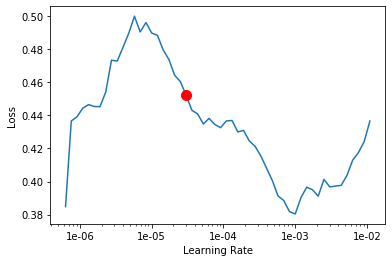

In [26]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [32]:
lr = 6e-3
learn.fit_one_cycle(3, lr)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Submission

In [39]:
sample_df = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
#sample_df = sample_df.rename(columns={'id_code': 'name', 'diagnosis': 'label'})
sample_df['path'] = sample_df['id_code'].apply(lambda x: os.path.join('data/test', x + '.png'))

In [ ]:
# optlr -- 
# valid_preds = learn.get_preds(ds_type=DatasetType.Valid)
# optR = OptimizedRounder()
# optR.fit(valid_preds[0],valid_preds[1])
# coefficients = optR.coefficients()
# print(coefficients)

In [61]:
preds = threshold_logits(preds)

In [62]:
sample_df.diagnosis = preds.astype(int)
sample_df.drop('path', axis=1, inplace=True)
sample_df.head()

id_code  diagnosis
0  0005cfc8afb6          2
1  003f0afdcd15          2
2  006efc72b638          2
3  00836aaacf06          2
4  009245722fa4          2

In [64]:
sub_name = 'submission_{}_{}_v2.csv'.format(EXPERIMENT_NAME, NUM_FOLD)
sample_df.to_csv(sub_name,index=False)